## Clustering

### Library import

In [56]:
library(haven)
library(dplyr)
library(cluster)
library(factoextra)
library(janitor)
library(mclust)  # 用於 GMM

Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa

Package 'mclust' version 6.1.2
Type 'citation("mclust")' for citing this R package in publications.


載入套件：‘mclust’


下列物件被遮斷自 ‘package:dplyr’:

    count




In [63]:
data_dir <- "."

# data <- read_xpt(file.path(data_dir,"DR1TOT_L.xpt")) %>% clean_names() %>% as.data.frame()
data_temp <- read_xpt(file.path(data_dir,"DR1TOT_L.xpt")) %>% clean_names() 
demo <- read_xpt(file.path(data_dir,"DEMO_L.xpt")) %>% clean_names()

data_temp2 <- demo %>%
  inner_join(data_temp, by="seqn")

data <- data_temp2 %>%
  filter(ridageyr >= 12 & ridageyr <= 18)

head(data)

seqn,sddsrvyr,ridstatr,riagendr,ridageyr,ridagemn,ridreth1,ridreth3,ridexmon,ridexagm,⋯,drd370qq,drd370r,drd370rq,drd370s,drd370sq,drd370t,drd370tq,drd370u,drd370uq,drd370v
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
130401,12,2,1,18,NA,3,3,1,222,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
130403,12,2,2,12,NA,2,2,1,147,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
130414,12,2,1,16,NA,1,1,1,196,⋯,NA,2,NA,2,NA,1,1,2,NA,2
130419,12,2,2,18,NA,5,6,1,220,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
130420,12,2,1,18,NA,3,3,1,223,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
130423,12,2,1,15,NA,2,2,1,191,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


### Select variable

In [62]:
set.seed(123)
vars <- data %>%
  dplyr::select(dr1tkcal, dr1tprot, dr1tcarb, dr1tsugr, dr1tfibe,
                dr1ttfat, dr1tchol, dr1tatoc, dr1tvara, dr1tvb1,
                dr1tvb2, dr1tvb6, dr1tvb12, dr1tvc, dr1tvd, dr1tcaff,
                dr1talco, dr1_320z) %>%
  na.omit() %>%
  sample_n(670)


### Heat map

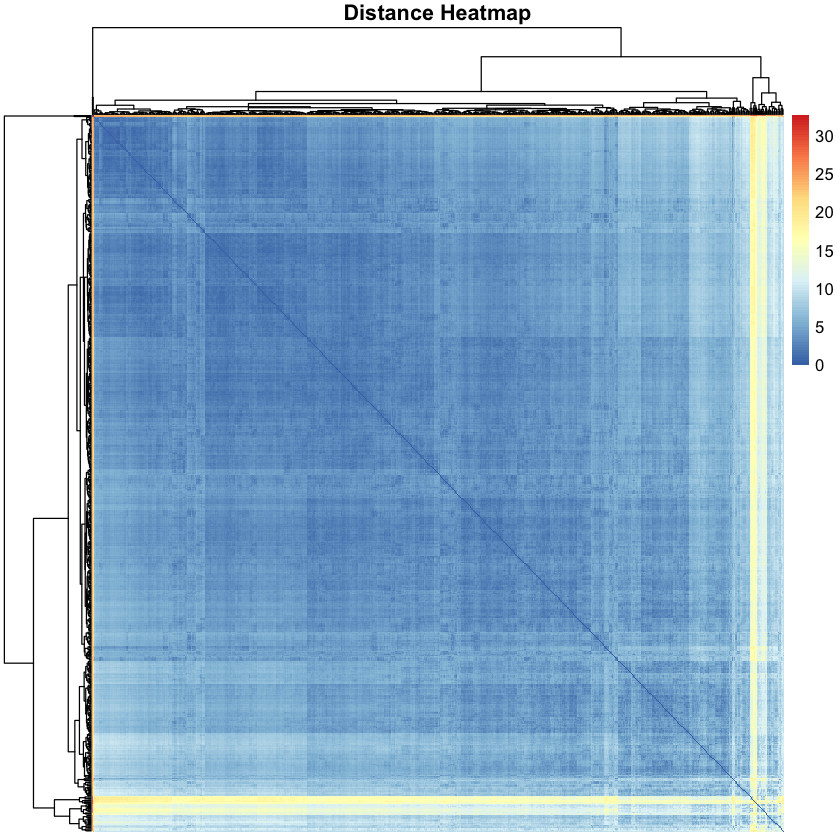

In [59]:
library(pheatmap)
pheatmap(dist(scale(vars), method = "euclidean"), 
         cluster_rows = T, cluster_cols = T, 
         main = "Distance Heatmap")



### Mahalanobis caculation

In [64]:
# 計算整體平均值向量和共變異矩陣
mu <- colMeans(vars)
S  <- cov(vars)

# 計算每個樣本到整體平均的 Mahalanobis 距離
# 用途：用於異常值檢測，因為離群點會和平均距離特別大
mahal <- mahalanobis(vars, center = mu, cov = S)

# 查看距離值的基本統計
summary(mahal)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.487   5.214   8.531  17.973  16.227 543.347 

### Shapiro-Wilk & Q-Q Plot Visualization
#### Q-Q Plot Visualization
- **Steps**:
  1. Set the graphics layout to 2×3 (`par(mfrow = c(2, 3))`) to display 6 plots at once
  2. Select 6 representative nutritional variables: `dr1tkcal` (total calories), `dr1tprot` (protein), `dr1tcarb` (carbohydrates), `dr1ttfat` (total fat), `dr1tchol` (cholesterol), `dr1tvc` (vitamin C)
  3. For each variable, create a Q-Q plot:
     - `qqnorm()`: Draws the quantile-quantile plot
     - `qqline()`: Adds a reference line for the theoretical normal distribution (in red)
     
  - **Interpretation**: If data points closely follow the red reference line, the variable is approximately normally distributed; if they deviate significantly, the variable does not follow a normal distribution

#### Shapiro-Wilk Normality Test
- **Purpose**: Use a statistical test to objectively determine whether variables follow a normal distribution

- **Steps**:
  1. Perform Shapiro-Wilk test on the same 6 variables
  2. Output the p-value for each variable
  3. Interpret based on p-value:
     - **p < 0.05**: Reject the null hypothesis, indicating the variable **does NOT follow a normal distribution**
     - **p ≥ 0.05**: Fail to reject the null hypothesis, indicating the variable **follows a normal distribution**

- **Interpretation**: Smaller p-values indicate stronger evidence that the data does not follow a normal distribution

- **Why Check for Normality?**: When performing outlier detection using Mahalanobis distance, the theoretical assumption is that the data follows a multivariate normal distribution. If the data does not follow a normal distribution, it may be necessary to adjust the outlier detection method or threshold setting strategy.

- **Result**: The Shapiro-Wilk test results show that **all 6 variables do NOT follow a normal distribution** (all p-values < 0.05):

Shapiro-Wilk 常態性檢定結果（p < 0.05 表示不符合常態分佈）：
dr1tkcal : p-value = 1.500695e-19  (不符合常態) 
dr1tprot : p-value = 3.029492e-24  (不符合常態) 
dr1tcarb : p-value = 3.685863e-20  (不符合常態) 
dr1ttfat : p-value = 1.722461e-19  (不符合常態) 
dr1tchol : p-value = 1.953768e-34  (不符合常態) 
dr1tvc : p-value = 3.731433e-29  (不符合常態) 


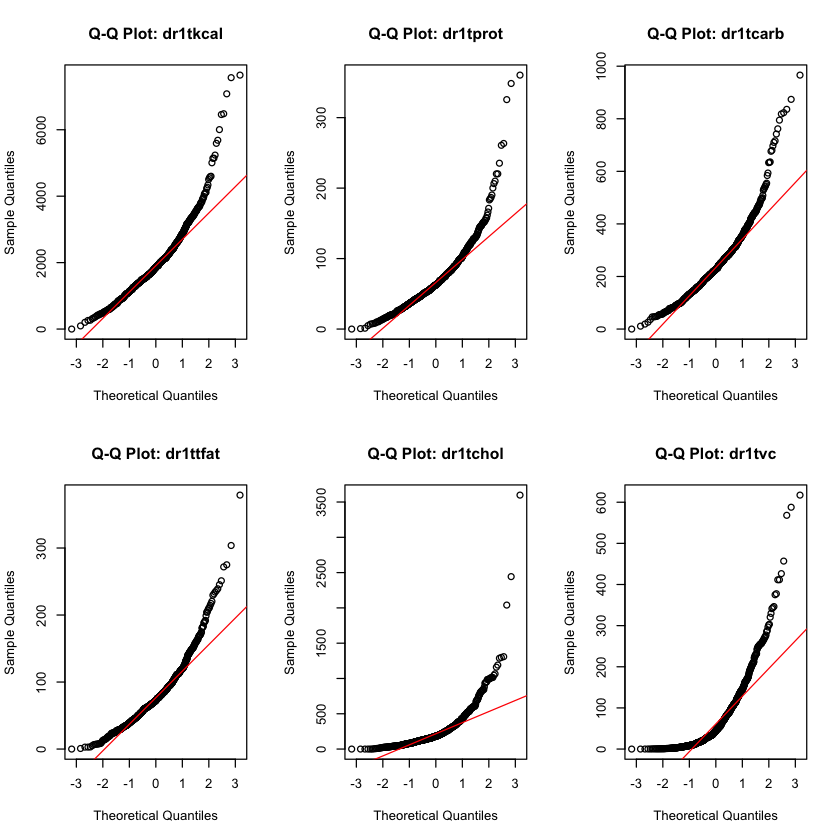

In [65]:
# ==============================
# 檢查多元正態分佈
# ==============================
library(ggplot2)

# 選取幾個代表性變數來檢查
par(mfrow = c(2, 3))
selected_vars <- c("dr1tkcal", "dr1tprot", "dr1tcarb", "dr1ttfat", "dr1tchol", "dr1tvc")
for(var in selected_vars) {
  qqnorm(vars[[var]], main = paste("Q-Q Plot:", var))
  qqline(vars[[var]], col = "red")
}

# Shapiro-Wilk 常態性檢定（針對幾個變數）
cat("Shapiro-Wilk 常態性檢定結果（p < 0.05 表示不符合常態分佈）：\n")
for(var in selected_vars) {
  test_result <- shapiro.test(vars[[var]])
  cat(var, ": p-value =", test_result$p.value, 
      ifelse(test_result$p.value < 0.05, " (不符合常態)", " (符合常態)"), "\n")
}

par(mfrow = c(1, 1))  # 重置圖形設定


### Threshold Setting

In [ ]:
# 由於資料不符合多元正態分佈，使用分位數方法來設定閾值

threshold_percentile_95 <- quantile(mahal, 0.95)      # 95th percentile

cat("使用分位數方法設定閾值：\n")
cat("95th percentile 閾值:", threshold_percentile_95, "\n\n")


# 使用 95th percentile 作為標準（較保守，只抓最極端的離群值）
threshold_final <- threshold_percentile_95
cat("===== 最終選擇的閾值 =====\n")
cat("閾值 (95th percentile):", threshold_final, "\n")

# 識別離群值
outliers <- mahal > threshold_final

# 統計離群值數量
cat("\n離群值數量:", sum(outliers), "\n")
cat("離群值百分比:", round(100 * mean(outliers), 2), "%\n")


使用分位數方法設定閾值：
95th percentile 閾值: 54.99104 

===== 最終選擇的閾值 =====
閾值 (95th percentile): 54.99104 

離群值數量: 34 
離群值百分比: 5.07 %


### Remove Outliers && Data Standardization

In [23]:
# Step 3: 篩除離群值
vars_clean <- vars[!outliers, ]

cat("原始資料筆數:", nrow(vars), "\n")
cat("篩除離群值後筆數:", nrow(vars_clean), "\n")
cat("移除的樣本數:", nrow(vars) - nrow(vars_clean), "\n")

# 將 vars_clean 設定為新的分析資料
vars <- vars_clean


原始資料筆數: 670 
篩除離群值後筆數: 636 
移除的樣本數: 34 


In [29]:
vars_scaled <- scale(vars_clean)

### Elbow method

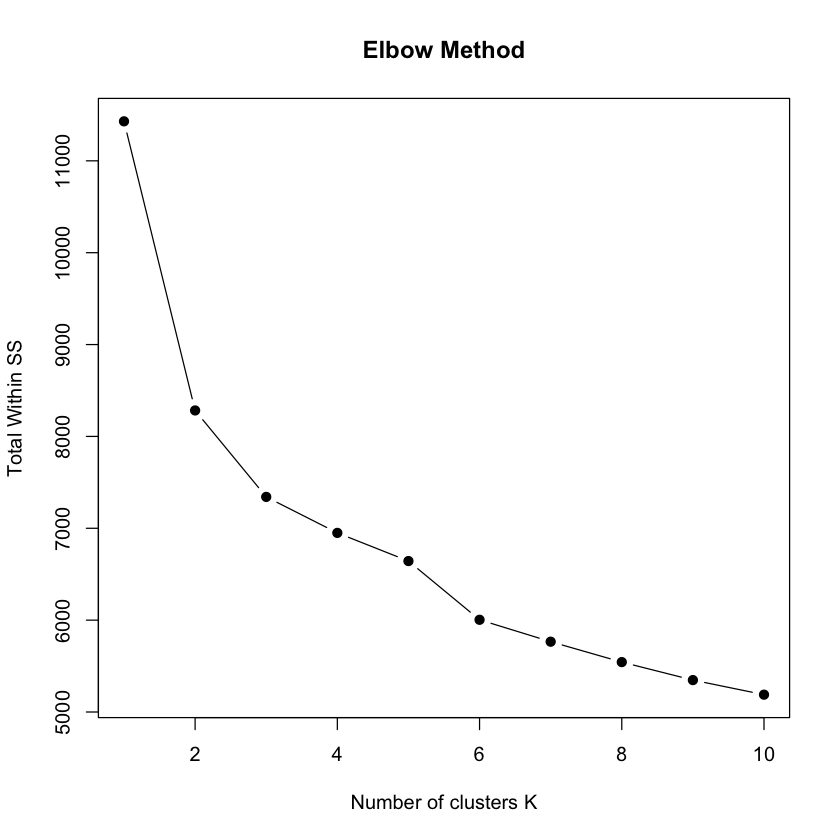

In [30]:
wss <- sapply(1:10, function(k){
  kmeans(vars_scaled, centers = k, nstart = 20)$tot.withinss
})

plot(1:10, wss, type="b", pch=19,
     xlab="Number of clusters K",
     ylab="Total Within SS",
     main="Elbow Method")


### Gap statistic

Warning message:
“10 迭代仍沒有聚合”
Warning message:
“10 迭代仍沒有聚合”
Warning message:
“10 迭代仍沒有聚合”
Warning message:
“10 迭代仍沒有聚合”


Gap 建議K = 2 


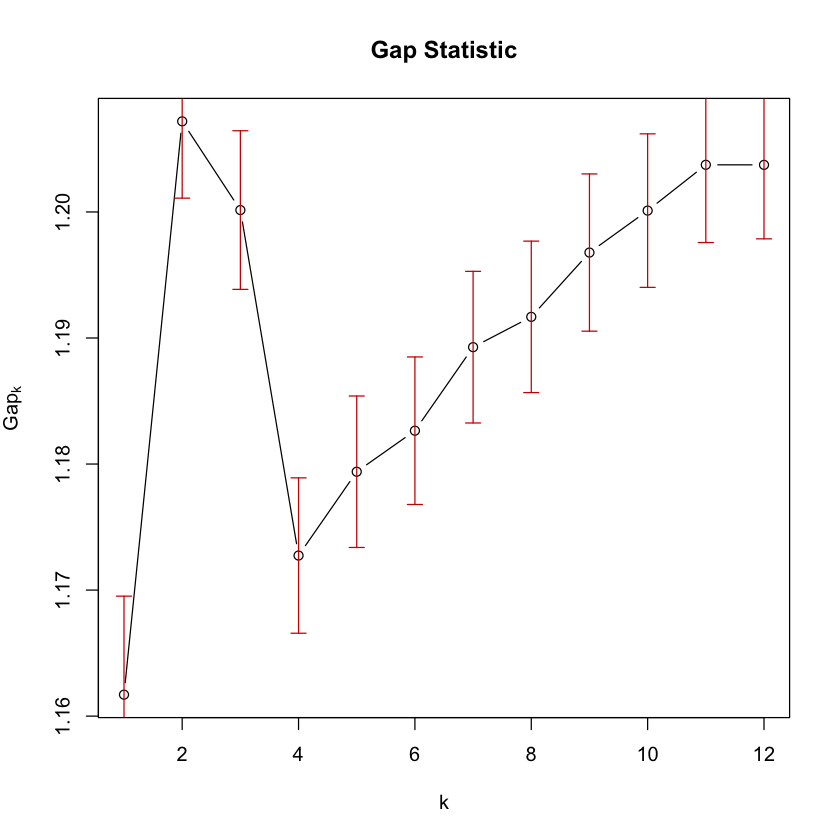

In [31]:
set.seed(123)
gap <- clusGap(vars_scaled, FUN = kmeans, nstart = 20, K.max = 12, B = 50)
plot(gap, main="Gap Statistic")
bestK_gap <- maxSE(gap$Tab[,"gap"], gap$Tab[,"SE.sim"], method="firstSEmax")
cat("Gap 建議K =", bestK_gap, "\n")


### Silhouette

In [49]:
sil <- fviz_nbclust(vars_scaled, kmeans, method="silhouette")
bestK_sil <- as.integer(sil$data$clusters[which.max(sil$data$y)])
cat("Silhouette 建議K =", bestK_sil, "\n")


Silhouette 建議K = 2 


In [38]:
set.seed(123)
km_result <- kmeans(vars_scaled, centers = bestK_sil, nstart = 20)

clusters <- km_result$cluster


### Identifying Best Discriminating Variables for Clustering Visualization

#### Step 1: Calculate Cluster Centers
- Compute the mean value of each variable for each cluster

#### Step 2: Calculate Cluster Center Distances
- For each variable, calculate the distance between cluster centers
- **2 clusters**: absolute difference between centers
- **Multiple clusters**: range (max - min) of centers
- Larger distances indicate better discrimination between clusters

#### Step 3: Select Best Variables
- Sort variables by distance and select the top 2
- **Result**: `dr1tkcal` and `dr1tvb2` are the best discriminating variables

#### Step 4: Visualize Clustering
- Create a 2D scatter plot using the two best variables
- Color points by cluster assignment
- Mark cluster centers with asterisks
- **Purpose**: Visualize high-dimensional clustering results in 2D space


**Why This Method?**: When dealing with high-dimensional data (18 nutritional variables), it's difficult to visualize all dimensions simultaneously. By identifying and plotting the two variables that best distinguish clusters, we can:
- Understand which variables are most important for cluster separation
- Validate the clustering results visually
- Communicate findings more effectively

===== 各聚類的中心（均值）=====
  cluster   dr1tkcal   dr1tprot   dr1tcarb   dr1tsugr   dr1tfibe   dr1ttfat
1       1  0.9659286  0.9001642  0.8880008  0.6989231  0.7150790  0.8246930
2       2 -0.5546917 -0.5169260 -0.5099410 -0.4013618 -0.4106394 -0.4735861
    dr1tchol   dr1tatoc   dr1tvara    dr1tvb1    dr1tvb2    dr1tvb6   dr1tvb12
1  0.5328723  0.6889303  0.7143172  0.8192715  0.9034491  0.7878362  0.7438557
2 -0.3060059 -0.3956233 -0.4102020 -0.4704727 -0.5188124 -0.4524208 -0.4271647
      dr1tvc     dr1tvd    dr1tcaff    dr1talco    dr1_320z
1  0.3435556  0.5665244  0.16373811 -0.03965258  0.08933981
2 -0.1972893 -0.3253309 -0.09402783  0.02277079 -0.05130405

===== 各變數的聚類中心距離（距離越大，區分度越高）=====
dr1tkcal  dr1tvb2 dr1tprot dr1tcarb dr1ttfat  dr1tvb1  dr1tvb6 dr1tvb12 
  1.5206   1.4223   1.4171   1.3979   1.2983   1.2897   1.2403   1.1710 
dr1tfibe dr1tvara dr1tsugr dr1tatoc   dr1tvd dr1tchol   dr1tvc dr1tcaff 
  1.1257   1.1245   1.1003   1.0846   0.8919   0.8389   0.5408   0.2578 
dr1_32

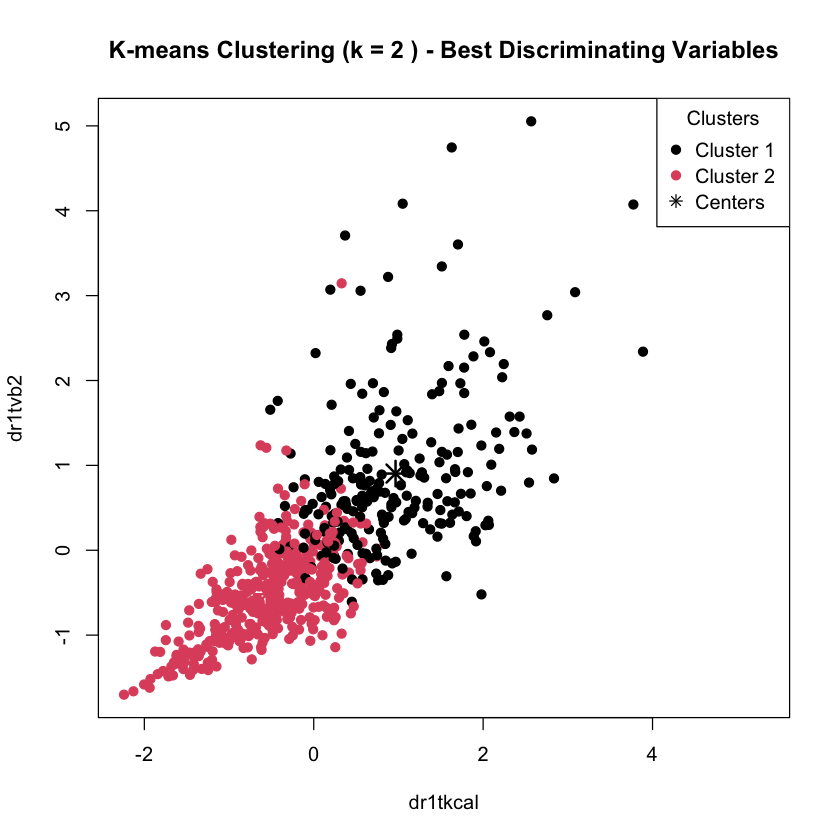

In [ ]:
# 步驟1：計算每個聚類的中心（每個變數的均值）
cluster_centers <- aggregate(vars_scaled, by = list(cluster = clusters), FUN = mean)

# 顯示聚類中心
cat("===== 各聚類的中心（均值）=====\n")
print(cluster_centers)
cat("\n")

# 步驟2：計算各聚類中心在每個變數上的距離
# 如果是2個聚類，計算兩個聚類中心在每個變數上的絕對差值
n_clusters <- length(unique(clusters))
var_names <- colnames(vars_scaled)

# 計算每個變數的聚類中心距離
center_distances <- numeric(length(var_names))
names(center_distances) <- var_names

# 將 cluster_centers 轉換為矩陣（排除 cluster 欄位）
centers_matrix <- as.matrix(cluster_centers[, var_names])

if(n_clusters == 2) {
  # 如果只有2個聚類，計算兩個中心在每個變數上的絕對差值
  for(i in 1:length(var_names)) {
    center_distances[i] <- abs(centers_matrix[1, var_names[i]] - centers_matrix[2, var_names[i]])
  }
} else {
  # 如果有多個聚類，計算所有聚類中心在該變數上的範圍（最大值 - 最小值）
  for(i in 1:length(var_names)) {
    center_distances[i] <- max(centers_matrix[, var_names[i]]) - min(centers_matrix[, var_names[i]])
  }
}

# 顯示每個變數的聚類中心距離（按距離排序）
cat("===== 各變數的聚類中心距離（距離越大，區分度越高）=====\n")
sorted_distances <- sort(center_distances, decreasing = TRUE)
print(round(sorted_distances, 4))
cat("\n")

# 步驟3：選擇距離最大的兩個變數
best_vars <- names(sorted_distances)[1:2]
cat("===== 最能區分聚類的兩個變數 =====\n")
cat("變數1:", best_vars[1], "(距離:", round(sorted_distances[best_vars[1]], 4), ")\n")
cat("變數2:", best_vars[2], "(距離:", round(sorted_distances[best_vars[2]], 4), ")\n")
cat("\n")

# 步驟4：繪製散點圖（使用選出的兩個變數）
plot(vars_scaled[, best_vars[1]], vars_scaled[, best_vars[2]],
     col = clusters,
     pch = 19,
     xlab = best_vars[1],
     ylab = best_vars[2],
     main = paste("K-means Clustering (k =", bestK_sil, ") - Best Discriminating Variables"))

# 添加聚類中心點
for(k in 1:n_clusters) {
  points(centers_matrix[k, best_vars[1]], 
         centers_matrix[k, best_vars[2]], 
         col = k, 
         pch = 8, 
         cex = 2, 
         lwd = 2)
}

# 添加圖例
legend("topright", 
       legend = c(paste("Cluster", unique(clusters)), "Centers"),
       col = c(unique(clusters), 1),
       pch = c(rep(19, n_clusters), 8),
       title = "Clusters")


### Discussion: Clustering Analysis Results

#### Differences Between Cluster 1 and Cluster 2

The K-means clustering analysis successfully partitioned the dataset into two distinct groups based on nutritional intake patterns. The analysis reveals significant differences between the two clusters across all nutritional variables.

**Cluster 1 (High Nutritional Intake Group):**
- Characterized by **positive mean values** across all nutritional variables
- Higher intake of total calories (`dr1tkcal`: 0.966), protein (`dr1tprot`: 0.900), carbohydrates (`dr1tcarb`: 0.888), and total fat (`dr1ttfat`: 0.825)
- Higher levels of vitamins, particularly Vitamin B2 (`dr1tvb2`: 0.903), Vitamin B1 (`dr1tvb1`: 0.819), and Vitamin B6 (`dr1tvb6`: 0.788)

**Cluster 2 (Low Nutritional Intake Group):**
- Characterized by **negative mean values** across all nutritional variables
- Lower intake of total calories (`dr1tkcal`: -0.555), protein (`dr1tprot`: -0.517), carbohydrates (`dr1tcarb`: -0.510), and total fat (`dr1ttfat`: -0.474)
- Lower levels of vitamins, particularly Vitamin B2 (`dr1tvb2`: -0.519), Vitamin B1 (`dr1tvb1`: -0.470), and Vitamin B6 (`dr1tvb6`: -0.452)

#### Key Discriminating Features

The variables with the largest differences between clusters are:

1. **Total Calories (`dr1tkcal`)**: Distance = 1.5206 - The most significant distinguishing factor
2. **Vitamin B2 (`dr1tvb2`)**: Distance = 1.4223 - Second most important factor
3. **Protein (`dr1tprot`)**: Distance = 1.4171
4. **Carbohydrates (`dr1tcarb`)**: Distance = 1.3979

These findings suggest that **overall caloric intake** and **micronutrient levels** (especially Vitamin B2) are the primary factors distinguishing the two groups.

#### Interpretation: What Do These Clusters Represent?

Based on the nutritional patterns, the two clusters likely represent:

- **Cluster 1**: Individuals with **higher overall nutritional intake**. This group may include:
  - Adolescents with higher caloric needs (e.g., more physically active individuals)
  - Those with better access to diverse, nutrient-rich foods
  - Individuals following a more comprehensive diet

- **Cluster 2**: Individuals with **lower overall nutritional intake**. This group may include:
  - Adolescents with lower caloric needs or reduced food intake
  - Those with limited access to diverse foods
  - Individuals with dietary restrictions or preferences leading to lower nutrient intake

The consistent pattern across all variables (Cluster 1 positive, Cluster 2 negative) suggests these groups differ in **overall dietary volume and quality** rather than specific nutrient preferences.

#### Rationale for Choosing K-means Clustering

K-means clustering was selected for this analysis for several reasons:

1. **Computational Efficiency**: K-means is computationally efficient and scalable, making it suitable for datasets with multiple variables and observations.

2. **Interpretability**: The cluster centroids (mean values) provide clear, interpretable summaries of each group's characteristics, as demonstrated by the cluster center analysis.

3. **Suitability for Continuous Data**: K-means is well-suited for continuous numerical data, which matches the nature of the nutritional variables (calories, grams, etc.).

4. **Optimal K Determination**: The use of multiple validation methods (Elbow method, Gap statistic, and Silhouette method) all consistently suggested K=2, providing strong evidence for a two-cluster solution.

5. **Clear Separation**: The distinct separation between clusters (one with positive values, one with negative values) indicates that K-means successfully identified meaningful dietary patterns in the data.

## Classification

In [1]:
library(haven)
library(dplyr)
library(janitor)

data_dir <- "."

bmx  <- read_xpt(file.path(data_dir,"BMX_L.XPT")) %>% clean_names()
demo <- read_xpt(file.path(data_dir,"DEMO_L.XPT")) %>% clean_names()
data_temp <- read_xpt(file.path(data_dir,"DR1TOT_L.xpt")) %>% clean_names()

data_class_temp <- demo %>%
  inner_join(bmx, by="seqn") %>%
  inner_join(data_temp, by="seqn")

data_class <- data_class_temp %>%
  filter(ridageyr >= 12 & ridageyr <= 18) %>%
  mutate(bmi_category = factor(
    case_when(
      bmxbmi < 18.5 ~ "Underweight",
      bmxbmi >= 18.5 & bmxbmi < 24 ~ "Normal",
      bmxbmi >= 24 & bmxbmi < 27 ~ "Overweight",
      bmxbmi >= 27 ~ "Obesity"
    ),
    levels = c("Underweight", "Normal", "Overweight", "Obesity")
  ))

head(data_class)


載入套件：‘dplyr’


下列物件被遮斷自 ‘package:stats’:

    filter, lag


下列物件被遮斷自 ‘package:base’:

    intersect, setdiff, setequal, union



載入套件：‘janitor’


下列物件被遮斷自 ‘package:stats’:

    chisq.test, fisher.test




seqn,sddsrvyr,ridstatr,riagendr,ridageyr,ridagemn,ridreth1,ridreth3,ridexmon,ridexagm,⋯,drd370r,drd370rq,drd370s,drd370sq,drd370t,drd370tq,drd370u,drd370uq,drd370v,bmi_category
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
130401,12,2,1,18,NA,3,3,1,222,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,Obesity
130403,12,2,2,12,NA,2,2,1,147,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,Overweight
130414,12,2,1,16,NA,1,1,1,196,⋯,2,NA,2,NA,1,1,2,NA,2,Obesity
130419,12,2,2,18,NA,5,6,1,220,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,Obesity
130420,12,2,1,18,NA,3,3,1,223,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,Obesity
130423,12,2,1,15,NA,2,2,1,191,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,Obesity


In [ ]:
set.seed(123)
# 選擇營養變數作為特徵，並保留 bmi_category 作為目標變數
dat_class <- data_class %>%
  dplyr::select(dr1tkcal, dr1tprot, dr1tcarb, dr1tsugr, dr1tfibe,
                dr1ttfat, dr1tchol, dr1tatoc, dr1tvara, dr1tvb1,
                dr1tvb2, dr1tvb6, dr1tvb12, dr1tvc, dr1tvd, dr1tcaff,
                dr1talco, dr1_320z, bmi_category) %>%
  na.omit()

# Train/Test split (70% / 30%)
n <- nrow(dat_class)
train_index <- sample(1:n, size = 0.7*n, replace = FALSE)

train <- dat_class[train_index, ]
test  <- dat_class[-train_index, ]

In [ ]:
# 載入分類模型所需的套件
library(class)   # kNN
library(tree)    # classification tree
library(rpart)   # rpart classification tree

# 標準化特徵變數
train_X <- scale(train[, 1:18])
test_X <- scale(test[, 1:18], 
                center = attr(train_X, "scaled:center"),
                scale = attr(train_X, "scaled:scale"))
train_y <- train$bmi_category
test_y <- test$bmi_category


### KNN

In [22]:
set.seed(123)
k_values <- seq(1, 40, by = 2)
cv_folds <- 5

# 創建折疊索引
n_train <- nrow(train_X)
fold_indices <- sample(rep(1:cv_folds, length.out = n_train))

# 儲存結果
cv_results <- data.frame(k = k_values, error = NA, acc = NA)

cat("5-fold Cross Validation...\n\n")

for (k in k_values) {
  fold_errors <- c()
  fold_accuracies <- c()
  
  for (fold in 1:cv_folds) {
    # 分割資料
    train_fold_X <- train_X[fold_indices != fold, ]
    train_fold_y <- train_y[fold_indices != fold]
    val_fold_X <- train_X[fold_indices == fold, ]
    val_fold_y <- train_y[fold_indices == fold]
    
    # kNN 預測
    knn_pred <- knn(train = train_fold_X, 
                    test = val_fold_X, 
                    cl = train_fold_y, 
                    k = k)
    
    # 確保 factor levels 一致
    knn_pred <- factor(knn_pred, levels = levels(train_y))
    val_fold_y <- factor(val_fold_y, levels = levels(train_y))
    
    # 計算錯誤率和準確率
    fold_errors <- c(fold_errors, mean(knn_pred != val_fold_y))
    fold_accuracies <- c(fold_accuracies, mean(knn_pred == val_fold_y))
  }
  
  cv_results[cv_results$k == k, "error"] <- mean(fold_errors)
  cv_results[cv_results$k == k, "acc"] <- mean(fold_accuracies)
  
  cat(sprintf("k = %d, 平均錯誤率 = %.4f, 平均準確率 = %.4f\n",
              k, mean(fold_errors), mean(fold_accuracies)))
}

# 最佳 k 值
best_k <- cv_results$k[which.min(cv_results$error)]
cat("\n===== 最佳 k 值 =====\n")
cat(sprintf("最佳 k = %d, 平均錯誤率 = %.4f, 平均準確率 = %.4f\n",
            best_k,
            cv_results$error[cv_results$k == best_k],
            cv_results$acc[cv_results$k == best_k]))



5-fold Cross Validation...

k = 1, 平均錯誤率 = 0.6701, 平均準確率 = 0.3299
k = 3, 平均錯誤率 = 0.6422, 平均準確率 = 0.3578
k = 5, 平均錯誤率 = 0.6424, 平均準確率 = 0.3576
k = 7, 平均錯誤率 = 0.6316, 平均準確率 = 0.3684
k = 9, 平均錯誤率 = 0.6252, 平均準確率 = 0.3748
k = 11, 平均錯誤率 = 0.6230, 平均準確率 = 0.3770
k = 13, 平均錯誤率 = 0.6080, 平均準確率 = 0.3920
k = 15, 平均錯誤率 = 0.6143, 平均準確率 = 0.3857
k = 17, 平均錯誤率 = 0.6080, 平均準確率 = 0.3920
k = 19, 平均錯誤率 = 0.5973, 平均準確率 = 0.4027
k = 21, 平均錯誤率 = 0.5888, 平均準確率 = 0.4112
k = 23, 平均錯誤率 = 0.5694, 平均準確率 = 0.4306
k = 25, 平均錯誤率 = 0.5758, 平均準確率 = 0.4242
k = 27, 平均錯誤率 = 0.5737, 平均準確率 = 0.4263
k = 29, 平均錯誤率 = 0.5780, 平均準確率 = 0.4220
k = 31, 平均錯誤率 = 0.5866, 平均準確率 = 0.4134
k = 33, 平均錯誤率 = 0.5780, 平均準確率 = 0.4220
k = 35, 平均錯誤率 = 0.5759, 平均準確率 = 0.4241
k = 37, 平均錯誤率 = 0.5759, 平均準確率 = 0.4241
k = 39, 平均錯誤率 = 0.5801, 平均準確率 = 0.4199

===== 最佳 k 值 =====
最佳 k = 23, 平均錯誤率 = 0.5694, 平均準確率 = 0.4306


### Classification Tree(tree)


Classification tree:
tree(formula = bmi_category ~ ., data = train)
Variables actually used in tree construction:
 [1] "dr1tcarb" "dr1tcaff" "dr1tsugr" "dr1tvb6"  "dr1tkcal" "dr1tfibe"
 [7] "dr1tvb2"  "dr1_320z" "dr1ttfat" "dr1tvc"   "dr1tchol" "dr1tvb12"
[13] "dr1tprot"
Number of terminal nodes:  26 
Residual mean deviance:  1.921 = 847 / 441 
Misclassification error rate: 0.4111 = 192 / 467 

             Actual
Predicted     Underweight Normal Overweight Obesity
  Underweight           4      7          0       8
  Normal               14     40         16      19
  Overweight            5     12          7       9
  Obesity               6     22          6      26

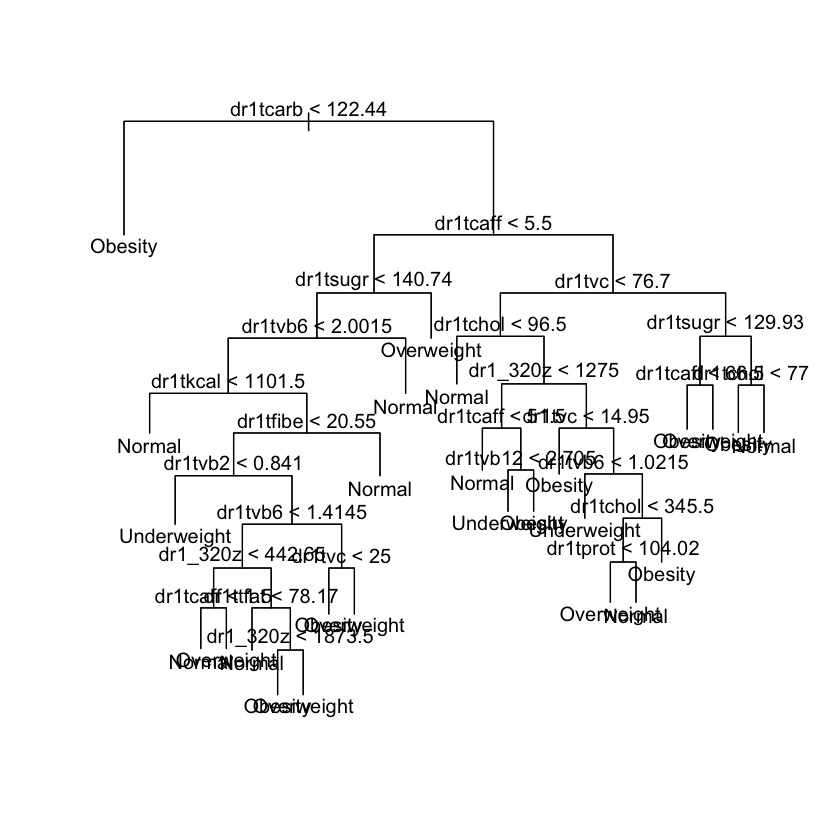

In [53]:
# ==============================
# Classification Tree
# ==============================
set.seed(123)

# 建立完整的樹模型
tree_fit <- tree(bmi_category ~ ., data = train)

summary(tree_fit)

# 繪製樹
plot(tree_fit)
text(tree_fit, pretty = 0)

# 預測
tree_pred <- predict(tree_fit, newdata = test, type = "class")
table(Predicted = tree_pred, Actual = test$bmi_category)

# Cross-validation（用於取得可能的樹大小）
cv_tree <- cv.tree(tree_fit, FUN = prune.misclass)

In [54]:
# 5-fold Cross Validation 來選擇最佳樹大小
set.seed(123)
cv_folds <- 5
n_train <- nrow(train)
fold_indices <- sample(rep(1:cv_folds, length.out = n_train))

# 取得可能的樹大小（排除 singlenode）
possible_sizes <- sort(unique(cv_tree$size))
possible_sizes <- possible_sizes[possible_sizes > 1]

cat("\n5-fold Cross Validation...\n\n")

# 儲存結果
cv_results <- data.frame(tree_size = possible_sizes, error = NA, acc = NA)

for (tree_size in possible_sizes) {
  fold_errors <- c()
  fold_accuracies <- c()
  
  for (fold in 1:cv_folds) {
    # 分割資料
    train_fold <- train[fold_indices != fold, ]
    val_fold <- train[fold_indices == fold, ]
    
    # 建立樹模型
    tree_fold <- tree(bmi_category ~ ., data = train_fold)
    
    # 剪枝
    tryCatch({
      pruned_tree <- prune.misclass(tree_fold, best = tree_size)
      
      # 檢查是否為 singlenode
      if (length(unique(pruned_tree$where)) == 1 || inherits(pruned_tree, "singlenode")) {
        most_common_class <- names(sort(table(train_fold$bmi_category), decreasing = TRUE))[1]
        tree_pred_fold <- factor(rep(most_common_class, nrow(val_fold)), 
                                 levels = levels(train$bmi_category))
      } else {
        tree_pred_fold <- predict(pruned_tree, newdata = val_fold, type = "class")
      }
    }, error = function(e) {
      tree_pred_fold <- predict(tree_fold, newdata = val_fold, type = "class")
    })
    
    # 計算錯誤率和準確率
    tree_pred_fold <- factor(tree_pred_fold, levels = levels(train$bmi_category))
    val_fold_y <- factor(val_fold$bmi_category, levels = levels(train$bmi_category))
    
    fold_errors <- c(fold_errors, mean(tree_pred_fold != val_fold_y))
    fold_accuracies <- c(fold_accuracies, mean(tree_pred_fold == val_fold_y))
  }
  
  cv_results[cv_results$tree_size == tree_size, "error"] <- mean(fold_errors)
  cv_results[cv_results$tree_size == tree_size, "acc"] <- mean(fold_accuracies)
  
  cat(sprintf("樹大小 = %d, 平均錯誤率 = %.4f, 平均準確率 = %.4f\n",
              tree_size, mean(fold_errors), mean(fold_accuracies)))
}

# 最佳樹大小
best_tree_size <- cv_results$tree_size[which.min(cv_results$error)]
cat("\n===== 最佳樹大小 =====\n")
cat(sprintf("最佳樹大小 = %d, 平均錯誤率 = %.4f, 平均準確率 = %.4f\n",
            best_tree_size,
            cv_results$error[cv_results$tree_size == best_tree_size],
            cv_results$acc[cv_results$tree_size == best_tree_size]))




5-fold Cross Validation...

樹大小 = 2, 平均錯誤率 = 0.5674, 平均準確率 = 0.4326
樹大小 = 9, 平均錯誤率 = 0.6423, 平均準確率 = 0.3577
樹大小 = 15, 平均錯誤率 = 0.6637, 平均準確率 = 0.3363


Warning message in prune.tree(tree = tree_fold, best = tree_size, method = "misclass"):
“best is bigger than tree size”


樹大小 = 21, 平均錯誤率 = 0.6702, 平均準確率 = 0.3298


Warning message in prune.tree(tree = tree_fold, best = tree_size, method = "misclass"):
“best is bigger than tree size”


樹大小 = 25, 平均錯誤率 = 0.6745, 平均準確率 = 0.3255


Warning message in prune.tree(tree = tree_fold, best = tree_size, method = "misclass"):
“best is bigger than tree size”


樹大小 = 26, 平均錯誤率 = 0.6766, 平均準確率 = 0.3234

===== 最佳樹大小 =====
最佳樹大小 = 2, 平均錯誤率 = 0.5674, 平均準確率 = 0.4326



Classification tree:
snip.tree(tree = tree_fit, nodes = 3L)
Variables actually used in tree construction:
[1] "dr1tcarb"
Number of terminal nodes:  2 
Residual mean deviance:  2.535 = 1179 / 465 
Misclassification error rate: 0.5589 = 261 / 467 


===== 剪枝後樹的測試集混淆矩陣 =====
             Actual
Predicted     Underweight Normal Overweight Obesity
  Underweight           0      0          0       0
  Normal               27     72         26      53
  Overweight            0      0          0       0
  Obesity               2      9          3       9

剪枝後樹的測試集準確率 = 0.4029851 


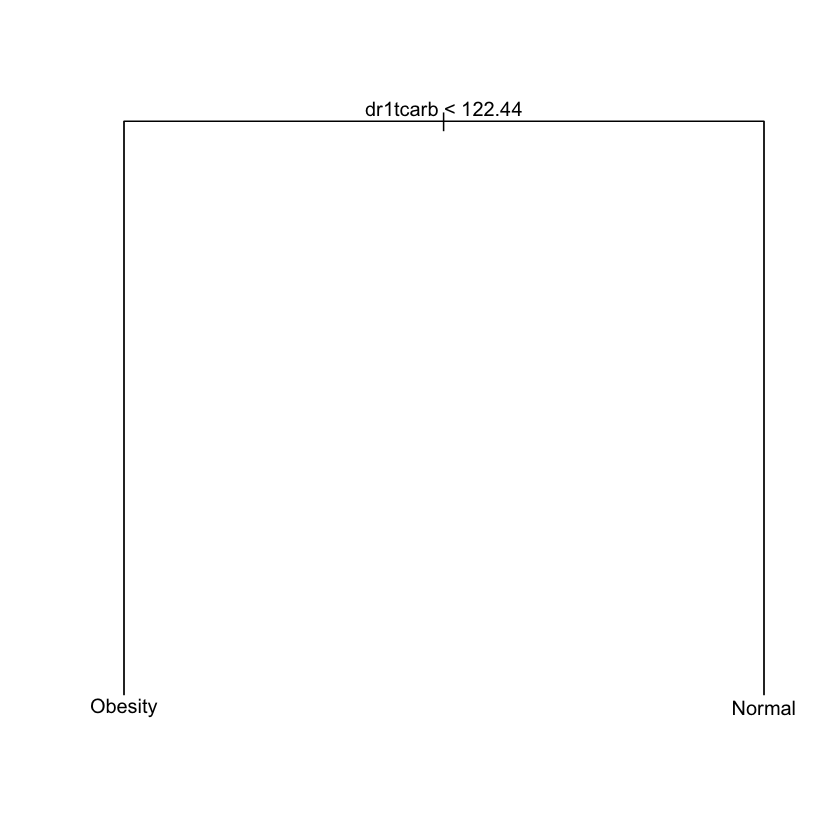

In [55]:
# 使用最佳樹大小進行剪枝
pruned_tree <- prune.misclass(tree_fit, best = best_tree_size)
summary(pruned_tree)

plot(pruned_tree)
text(pruned_tree, pretty = 0)

# 在測試集上評估剪枝後的樹
tree_pred_pruned <- predict(pruned_tree, newdata = test, type = "class")
cat("\n===== 剪枝後樹的測試集混淆矩陣 =====\n")
print(table(Predicted = tree_pred_pruned, Actual = test$bmi_category))
cat("\n剪枝後樹的測試集準確率 =", mean(tree_pred_pruned == test$bmi_category), "\n")


### Classification tree(rpart)

             Actual
Predicted     Underweight Normal Overweight Obesity
  Underweight           4      9          0       8
  Normal               19     48         19      33
  Overweight            2      6          3       6
  Obesity               4     18          7      15


Classification tree:
rpart(formula = bmi_category ~ ., data = train)

Variables actually used in tree construction:
 [1] dr1tatoc dr1tcaff dr1tcarb dr1tchol dr1tfibe dr1tkcal dr1ttfat dr1tvara
 [9] dr1tvb2  dr1tvb6  dr1tvd  

Root node error: 270/467 = 0.57816

n= 467 

        CP nsplit rel error  xerror     xstd
1 0.037037      0   1.00000 1.00000 0.039527
2 0.014815      1   0.96296 0.97407 0.039698
3 0.011111     12   0.77037 1.05556 0.039033
4 0.010000     15   0.73704 1.10000 0.038511


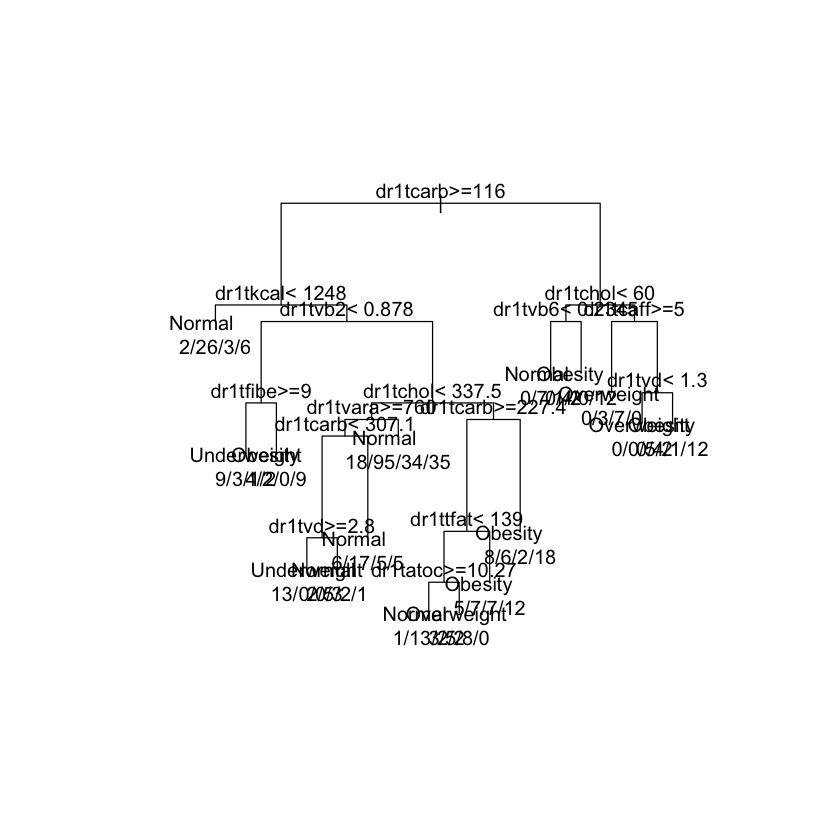

In [51]:
# ==============================
# Classification Tree (rpart)
# ==============================
set.seed(123)

# 建立 rpart 樹模型
rpart_fit <- rpart(bmi_category ~ ., data = train)

# 繪製 rpart 樹
plot(rpart_fit, margin = 0.2)
text(rpart_fit, use.n = T)

# 預測
rpart_pred <- predict(rpart_fit, newdata = test, type = "class")
table(Predicted = rpart_pred, Actual = test$bmi_category)

# Pruning
printcp(rpart_fit)  # complexity parameter table

In [67]:
# 簡單的 5-fold Cross Validation 來選擇最佳 cp 值
set.seed(123)
cv_folds <- 5
n_train <- nrow(train)
fold_indices <- sample(rep(1:cv_folds, length.out = n_train))

cp_table <- rpart_fit$cptable
possible_cps <- sort(unique(cp_table[, "CP"]), decreasing = TRUE)

cat("\n5-fold Cross Validation...\n\n")
cv_results <- data.frame(cp = possible_cps, error = NA, acc = NA)

for (cp_val in possible_cps) {
  fold_errors <- c()
  fold_accuracies <- c()
  
  for (fold in 1:cv_folds) {
    train_fold <- train[fold_indices != fold, ]
    val_fold <- train[fold_indices == fold, ]
    
    rpart_fold <- rpart(bmi_category ~ ., data = train_fold)
    pruned_rpart <- prune(rpart_fold, cp = cp_val)
    
    if (nrow(pruned_rpart$frame) > 1) {
      rpart_pred_fold <- predict(pruned_rpart, newdata = val_fold, type = "class")
    } else {
      most_common_class <- names(sort(table(train_fold$bmi_category), decreasing = TRUE))[1]
      rpart_pred_fold <- factor(rep(most_common_class, nrow(val_fold)), 
                                levels = levels(train$bmi_category))
    }
    
    rpart_pred_fold <- factor(rpart_pred_fold, levels = levels(train$bmi_category))
    val_fold_y <- factor(val_fold$bmi_category, levels = levels(train$bmi_category))
    fold_errors <- c(fold_errors, mean(rpart_pred_fold != val_fold_y))
    fold_accuracies <- c(fold_accuracies, mean(rpart_pred_fold == val_fold_y))
  }
  
  cv_results[cv_results$cp == cp_val, "error"] <- mean(fold_errors)
  cv_results[cv_results$cp == cp_val, "acc"] <- mean(fold_accuracies)
  cat(sprintf("cp = %.4f, 平均錯誤率 = %.4f, 平均準確率 = %.4f\n", 
              cp_val, mean(fold_errors), mean(fold_accuracies)))
}

best_cp <- cv_results$cp[which.min(cv_results$error)]
cat("\n===== 最佳 cp 值 =====\n")
cat(sprintf("最佳 cp = %.4f, 平均錯誤率 = %.4f, 平均準確率 = %.4f\n",
            best_cp,
            cv_results$error[cv_results$cp == best_cp],
            cv_results$acc[cv_results$cp == best_cp]))

# 使用最佳 cp 值進行剪枝
pruned_rpart <- prune(rpart_fit, cp = best_cp)

# 檢查是否為根節點（只有根節點無法繪製）
if (nrow(pruned_rpart$frame) > 1) {
  plot(pruned_rpart, margin = 0.2)
  text(pruned_rpart, use.n = TRUE)
} else {
  cat("\n警告：剪枝後的樹只剩下根節點，無法繪製樹圖\n")
}



5-fold Cross Validation...

cp = 0.0370, 平均錯誤率 = 0.5738, 平均準確率 = 0.4262
cp = 0.0148, 平均錯誤率 = 0.6017, 平均準確率 = 0.3983
cp = 0.0111, 平均錯誤率 = 0.6231, 平均準確率 = 0.3769
cp = 0.0100, 平均錯誤率 = 0.6253, 平均準確率 = 0.3747

===== 最佳 cp 值 =====
最佳 cp = 0.0370, 平均錯誤率 = 0.5738, 平均準確率 = 0.4262

警告：剪枝後的樹只剩下根節點，無法繪製樹圖


## Discussion: Classification Results

### Model Performance Summary

Three classification models were applied to predict BMI categories (Underweight, Normal, Overweight, Obesity) based on 18 nutritional variables for adolescents aged 12-18 years:

1. **K-Nearest Neighbors (KNN)**: Best k = 23, cross-validation accuracy = 43.06%
2. **Classification Tree (tree package)**: Best tree size = 2, cross-validation accuracy = 43.26%, test accuracy = 40.30%
3. **Classification Tree (rpart package)**: Best cp = 0.0370, cross-validation accuracy = 42.62%, pruned to root node only

All three models achieved relatively low accuracy rates (approximately 40-43%), indicating limited predictive power of nutritional variables alone for BMI category classification.

### Key Findings and Issues

#### 1. Both Tree Models Pruned to Root Node Only

Both classification tree models (tree and rpart packages) were pruned to contain only the root node, indicating that the optimal model complexity is the simplest possible configuration - essentially predicting the most common class for all observations without any splits.

**Possible Reasons:**
- **Class Imbalance**: The dataset likely exhibits a highly imbalanced distribution of BMI categories, with one category (likely "Normal") dominating the dataset. When the majority class represents a large proportion of the data, tree models may determine that no splits improve prediction accuracy beyond simply predicting the majority class.
- **Weak Feature-Target Relationship**: The nutritional variables may have weak predictive power for BMI categories. The relationship between nutritional intake and BMI category may not be strong enough for tree models to identify meaningful splits that improve classification performance.
- **Overfitting Prevention**: The cross-validation process identified that simpler models (root node only) generalize better than complex trees, suggesting that patterns found in training data do not hold consistently across validation sets. This indicates that increasing model complexity leads to overfitting rather than improved generalization.
- **High Baseline Accuracy**: If predicting the majority class already achieves relatively high accuracy, tree models may not find splits that significantly improve upon this baseline, leading to the selection of the simplest model.

#### 2. Pruned Models Essentially Predict a Single Class

The confusion matrix from the pruned tree model reveals a critical issue - the model predicts almost all observations as "Normal", regardless of their actual BMI category.
This pattern indicates that the model is essentially "guessing" the majority class for all predictions, which explains the low but not random accuracy (~40%). Notably, the model completely fails to predict "Underweight" and "Overweight" categories (all zeros in those prediction rows), and heavily favors predicting "Normal" across all actual categories.

**Possible Reasons:**
- **Majority Class Dominance**: The "Normal" BMI category likely represents the largest proportion of the dataset. When a tree is pruned to the root node, it predicts the most frequent class from the training data, which appears to be "Normal". This creates a model that simply assigns all observations to the majority class.
- **Insufficient Discriminative Power**: The nutritional variables may not provide enough information to distinguish between BMI categories. The relationship between diet and BMI may be more complex than what these variables capture, potentially confounded by other factors such as physical activity levels, metabolic rates, genetic factors, or lifestyle behaviors that are not included in the model.
- **Data Quality Issues**: Measurement errors, missing data patterns, or the specific characteristics of the adolescent age group (12-18 years) may limit the predictive power of nutritional variables for BMI classification. Adolescents may have more variable eating patterns or metabolic rates that make prediction more challenging.
- **Non-linear Relationships**: The relationship between nutritional intake and BMI categories may be non-linear or involve complex interactions that simple tree models cannot capture effectively.

### Overall Assessment

The low accuracy across all models (~40-43%) and the tendency of tree models to collapse to root nodes suggest several important limitations:

1. **Limited Predictive Power**: Nutritional variables alone may not be sufficient to accurately predict BMI categories in adolescents aged 12-18. Other factors such as physical activity levels, genetics, metabolism, sleep patterns, and lifestyle behaviors may play more significant roles in determining BMI categories than dietary intake alone.

2. **Class Imbalance**: The dominance of one class (likely "Normal") makes it challenging for models to learn meaningful patterns for minority classes. This imbalance leads to models that favor the majority class, resulting in poor performance for underrepresented categories.

3. **Model Complexity vs. Performance**: The fact that tree models prefer the simplest possible model (root node only) suggests that increasing model complexity does not improve generalization. This indicates fundamental limitations in the feature-target relationship rather than issues with model selection or hyperparameter tuning.

4. **Feature Limitations**: The 18 nutritional variables may not capture the full complexity of the relationship between diet and BMI. Factors such as meal timing, food quality, eating patterns, and individual metabolic differences may be more important than total nutrient intake.

### Recommendations

1. **Feature Engineering**: Consider adding non-nutritional features such as physical activity levels, sleep patterns, family history of obesity, socioeconomic status, or lifestyle factors that may better predict BMI categories.

2. **Address Class Imbalance**: Use techniques such as SMOTE (Synthetic Minority Oversampling Technique), class weighting, stratified sampling, or cost-sensitive learning to better handle imbalanced classes and improve prediction for minority categories.

3. **Alternative Models**: Consider ensemble methods (Random Forest, Gradient Boosting) or more sophisticated algorithms that may better capture complex, non-linear relationships between features and target variables.

4. **Data Collection**: Expand the dataset to include more balanced representation across all BMI categories and additional relevant features that may improve predictive power.

5. **Model Interpretation**: Further investigate why nutritional variables show limited predictive power. This may involve domain expertise consultation or additional exploratory data analysis to understand the underlying relationships.